In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import pqcd

from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre, 
    nsat
)

from scipy.interpolate import interp1d

In [2]:
pqcd_region_dict = pqcd.get_pqcd_region()

Text(0.5, 0, '$\\mu$ [GeV]')

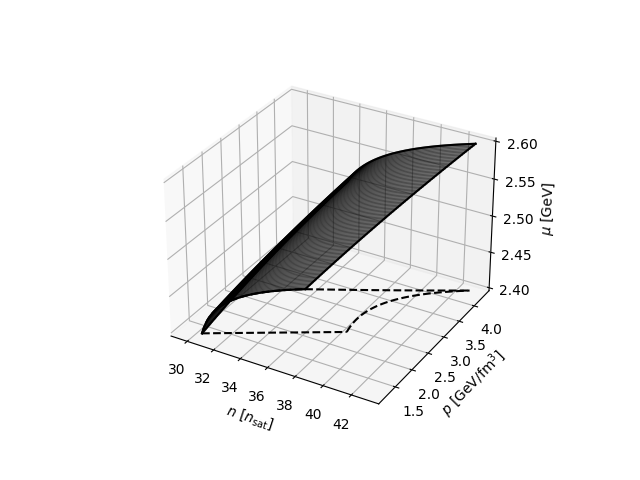

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(4):
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_boundary_arrays'][i],
        c='k'
        )
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_array'][0],
        c='k',
        ls='--'
    )
    
for mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
    ax.plot(np.array(dense_n_array)/nsat, dense_p_array, mu, c='k', alpha=0.5)

ax.set_xlabel(r'$n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')
ax.set_zlabel(r'$\mu$ [GeV]')

In [4]:
# Overplot some EOSs

N_samp = 1000

sets = [0]
good_EOSs = {s: [] for s in sets}

for s in sets:
    for variety in ['had', 'hyp', 'qrk']:
        for ni in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, ni))

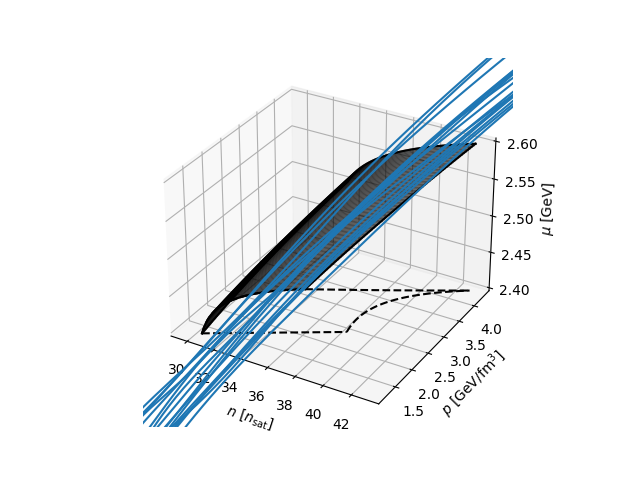

In [5]:
# Full EOS

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(4):
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_boundary_arrays'][i],
        c='k'
        )
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_array'][0],
        c='k',
        ls='--'
    )
    
for mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
    ax.plot(np.array(dense_n_array)/nsat, dense_p_array, mu, c='k', alpha=0.5)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

for s in sets:
    for variety, ni in good_EOSs[s]:

        eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')

        pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
        energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
        number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

        chemical_potential = (energy_density+pressure)/number_density

        ax.plot(
            number_density/nsat, 
            pressure,
            chemical_potential,
            c='C0'
        )

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_xlabel(r'$n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')
_ = ax.set_zlabel(r'$\mu$ [GeV]')

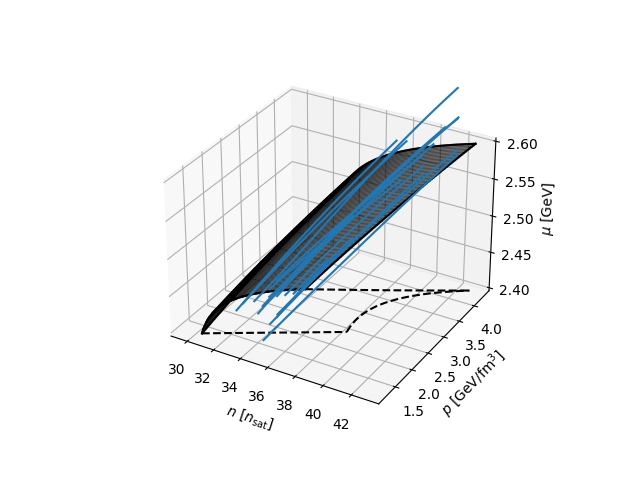

In [6]:
# Windowed EOS

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(4):
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_boundary_arrays'][i],
        c='k'
        )
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_array'][0],
        c='k',
        ls='--'
    )
    
for mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
    ax.plot(np.array(dense_n_array)/nsat, dense_p_array, mu, c='k', alpha=0.5)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

for s in sets:
    for variety, ni in good_EOSs[s]:

        eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')

        pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
        energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
        number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

        chemical_potential = (energy_density+pressure)/number_density

        inside_region_n = []
        inside_region_p = []
        inside_region_mu = []

        for n, p, mu in zip(number_density, pressure, chemical_potential):
            if pqcd_region_dict['p_boundary_min'] < p < pqcd_region_dict['p_boundary_max']:
                min_n = pqcd_region_dict['left_n_boundary'][np.argmin(np.abs(pqcd_region_dict['left_p_boundary']-p))]
                max_n = pqcd_region_dict['right_n_boundary'][np.argmin(np.abs(pqcd_region_dict['right_p_boundary']-p))]
                if min_n < n < max_n:
                    inside_region_n.append(n)
                    inside_region_p.append(p)
                    inside_region_mu.append(mu)

        ax.plot(
            np.array(inside_region_n)/nsat, 
            inside_region_p,
            inside_region_mu,
            c='C0'
        )

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_xlabel(r'$n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')
_ = ax.set_zlabel(r'$\mu$ [GeV]')